# Telecom Customer Churn Prediction

## Overview 
This project focuses on predicting customer churn for a telecommunications company in California (Q2 2022).  
Customer churn prediction is a key business problem because retaining an existing customer is often cheaper than acquiring a new one.

The objectives of this notebook are to:

- Perform data cleaning and preprocessing on a real-world churn dataset
- Explore key churn-related patterns through EDA
- Build and compare multiple classification models:
  - Logistic Regression
  - Random Forest
  - XGBoost
- Evaluate models using robust metrics such as **ROC-AUC**, **F1-score**, and **confusion matrix**
- Tune decision thresholds to improve churn detection performance

## Dataset Description

This dataset contains **2 CSV tables**:

### **Customer Churn Table**
- Contains information on **7,043 customers** from a Telecommunications company in California in **Q2 2022**
- Each row represents one customer
- Includes:
  - Demographics (e.g., gender, age, dependents)
  - Location information (e.g., city, zip code, latitude/longitude)
  - Subscription services (e.g., Internet type, streaming, security)
  - Billing and contract information
  - Customer status for the quarter (**Joined / Stayed / Churned**)

### **Zip Code Population Table**
- Contains estimated **population values** for zip codes in California
- Can be merged with the churn table using **Zip Code**


## 1. Environment Setup

In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve, auc

from scipy.stats import randint, uniform
from xgboost import XGBClassifier


## 2. Load Data & Initial Inspection

In [3]:
df = pd.read_csv("dataset/telecom_customer_churn.csv")
df.head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


In [4]:
print(f"This dataset contains: {df.shape[0]} customers and {df.shape[1]} features.")
print("List of features:")
print(df.columns)

This dataset contains: 7043 customers and 38 features.
List of features:
Index(['Customer ID', 'Gender', 'Age', 'Married', 'Number of Dependents',
       'City', 'Zip Code', 'Latitude', 'Longitude', 'Number of Referrals',
       'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Customer Status', 'Churn Category', 'Churn Reason'],
      dtype='object')


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Married                            7043 non-null   object 
 4   Number of Dependents               7043 non-null   int64  
 5   City                               7043 non-null   object 
 6   Zip Code                           7043 non-null   int64  
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Number of Referrals                7043 non-null   int64  
 10  Tenure in Months                   7043 non-null   int64  
 11  Offer                              3166 non-null   objec

## Missing Values Handling

We can observe that several columns contain **missing values**, particularly those related to optional services and usage metrics.  

Before imputing, we confirm patterns such as:

- `Multiple Lines` is only relevant when `Phone Service = Yes`
- Internet add-ons (e.g., Online Security, Streaming TV) are only relevant when `Internet Service = Yes`



In [6]:
print(pd.crosstab(df["Phone Service"], df["Multiple Lines"], dropna=False))
print()
print(pd.crosstab(
    df["Internet Service"],
    df["Avg Monthly GB Download"].isna(),
    colnames=["Avg Monthly GB Download Is Missing?"]
))

Multiple Lines    No   Yes  NaN
Phone Service                  
No                 0     0  682
Yes             3390  2971    0

Avg Monthly GB Download Is Missing?  False  True 
Internet Service                                 
No                                       0   1526
Yes                                   5517      0


In [7]:
internet_addons = [
    "Online Security", "Online Backup", "Device Protection Plan",
    "Premium Tech Support", "Streaming TV", "Streaming Movies",
    "Streaming Music", "Unlimited Data", "Internet Type"
]

missing_rate = (
    df[internet_addons]
    .isna()
    .groupby(df["Internet Service"])
    .mean()
    .T
)

missing_rate.columns = [f"Missing Rate (Internet Service={c})" for c in missing_rate.columns]
missing_rate


,Missing Rate (Internet Service=No),Missing Rate (Internet Service=Yes)
Online Security,1.0,0.0
Online Backup,1.0,0.0
Device Protection Plan,1.0,0.0
Premium Tech Support,1.0,0.0
Streaming TV,1.0,0.0
Streaming Movies,1.0,0.0
Streaming Music,1.0,0.0
Unlimited Data,1.0,0.0
Internet Type,1.0,0.0


Based on the results, we apply **domain-informed imputation rules** to ensure the dataset remains complete for modeling.

- **Categorical service-related fields** (e.g., *Offer*, *Multiple Lines*, *Internet Type*, and various internet add-ons) will be filled with values such as:
  - `"None"` - when a service category does not apply (e.g. no offer accepted, no internet type)
  - `"No"` - when the customer does not subscribe to the add-on service (e.g. Online Security, Streaming TV)

- **Numeric usage/charge fields** (e.g., *Avg Monthly Long Distance Charges*, *Avg Monthly GB Download*) will be filled with:
  - `0` - representing no usage or no applicable service activity

This approach preserves as much information as possible while ensuring the data remains consistent and fully usable for downstream preprocessing, feature encoding, and machine learning model training.

In [8]:
df["Offer"] = df["Offer"].fillna("None")
df["Avg Monthly Long Distance Charges"] = df["Avg Monthly Long Distance Charges"].fillna(0)
df["Multiple Lines"] = df["Multiple Lines"].fillna("No")
df["Internet Type"] = df["Internet Type"].fillna("None")
df["Avg Monthly GB Download"] = df["Avg Monthly GB Download"].fillna(0)

for col in internet_addons:
    df[col] = df[col].fillna("No")

In [9]:
df.isnull().sum()


Customer ID                             0
Gender                                  0
Age                                     0
Married                                 0
Number of Dependents                    0
City                                    0
Zip Code                                0
Latitude                                0
Longitude                               0
Number of Referrals                     0
Tenure in Months                        0
Offer                                   0
Phone Service                           0
Avg Monthly Long Distance Charges       0
Multiple Lines                          0
Internet Service                        0
Internet Type                           0
Avg Monthly GB Download                 0
Online Security                         0
Online Backup                           0
Device Protection Plan                  0
Premium Tech Support                    0
Streaming TV                            0
Streaming Movies                  

## 3. Explanatory Data Analysis (EDA)

### Distribution of Numerical Features

We first visualize the distribution of numerical variables using histograms.  

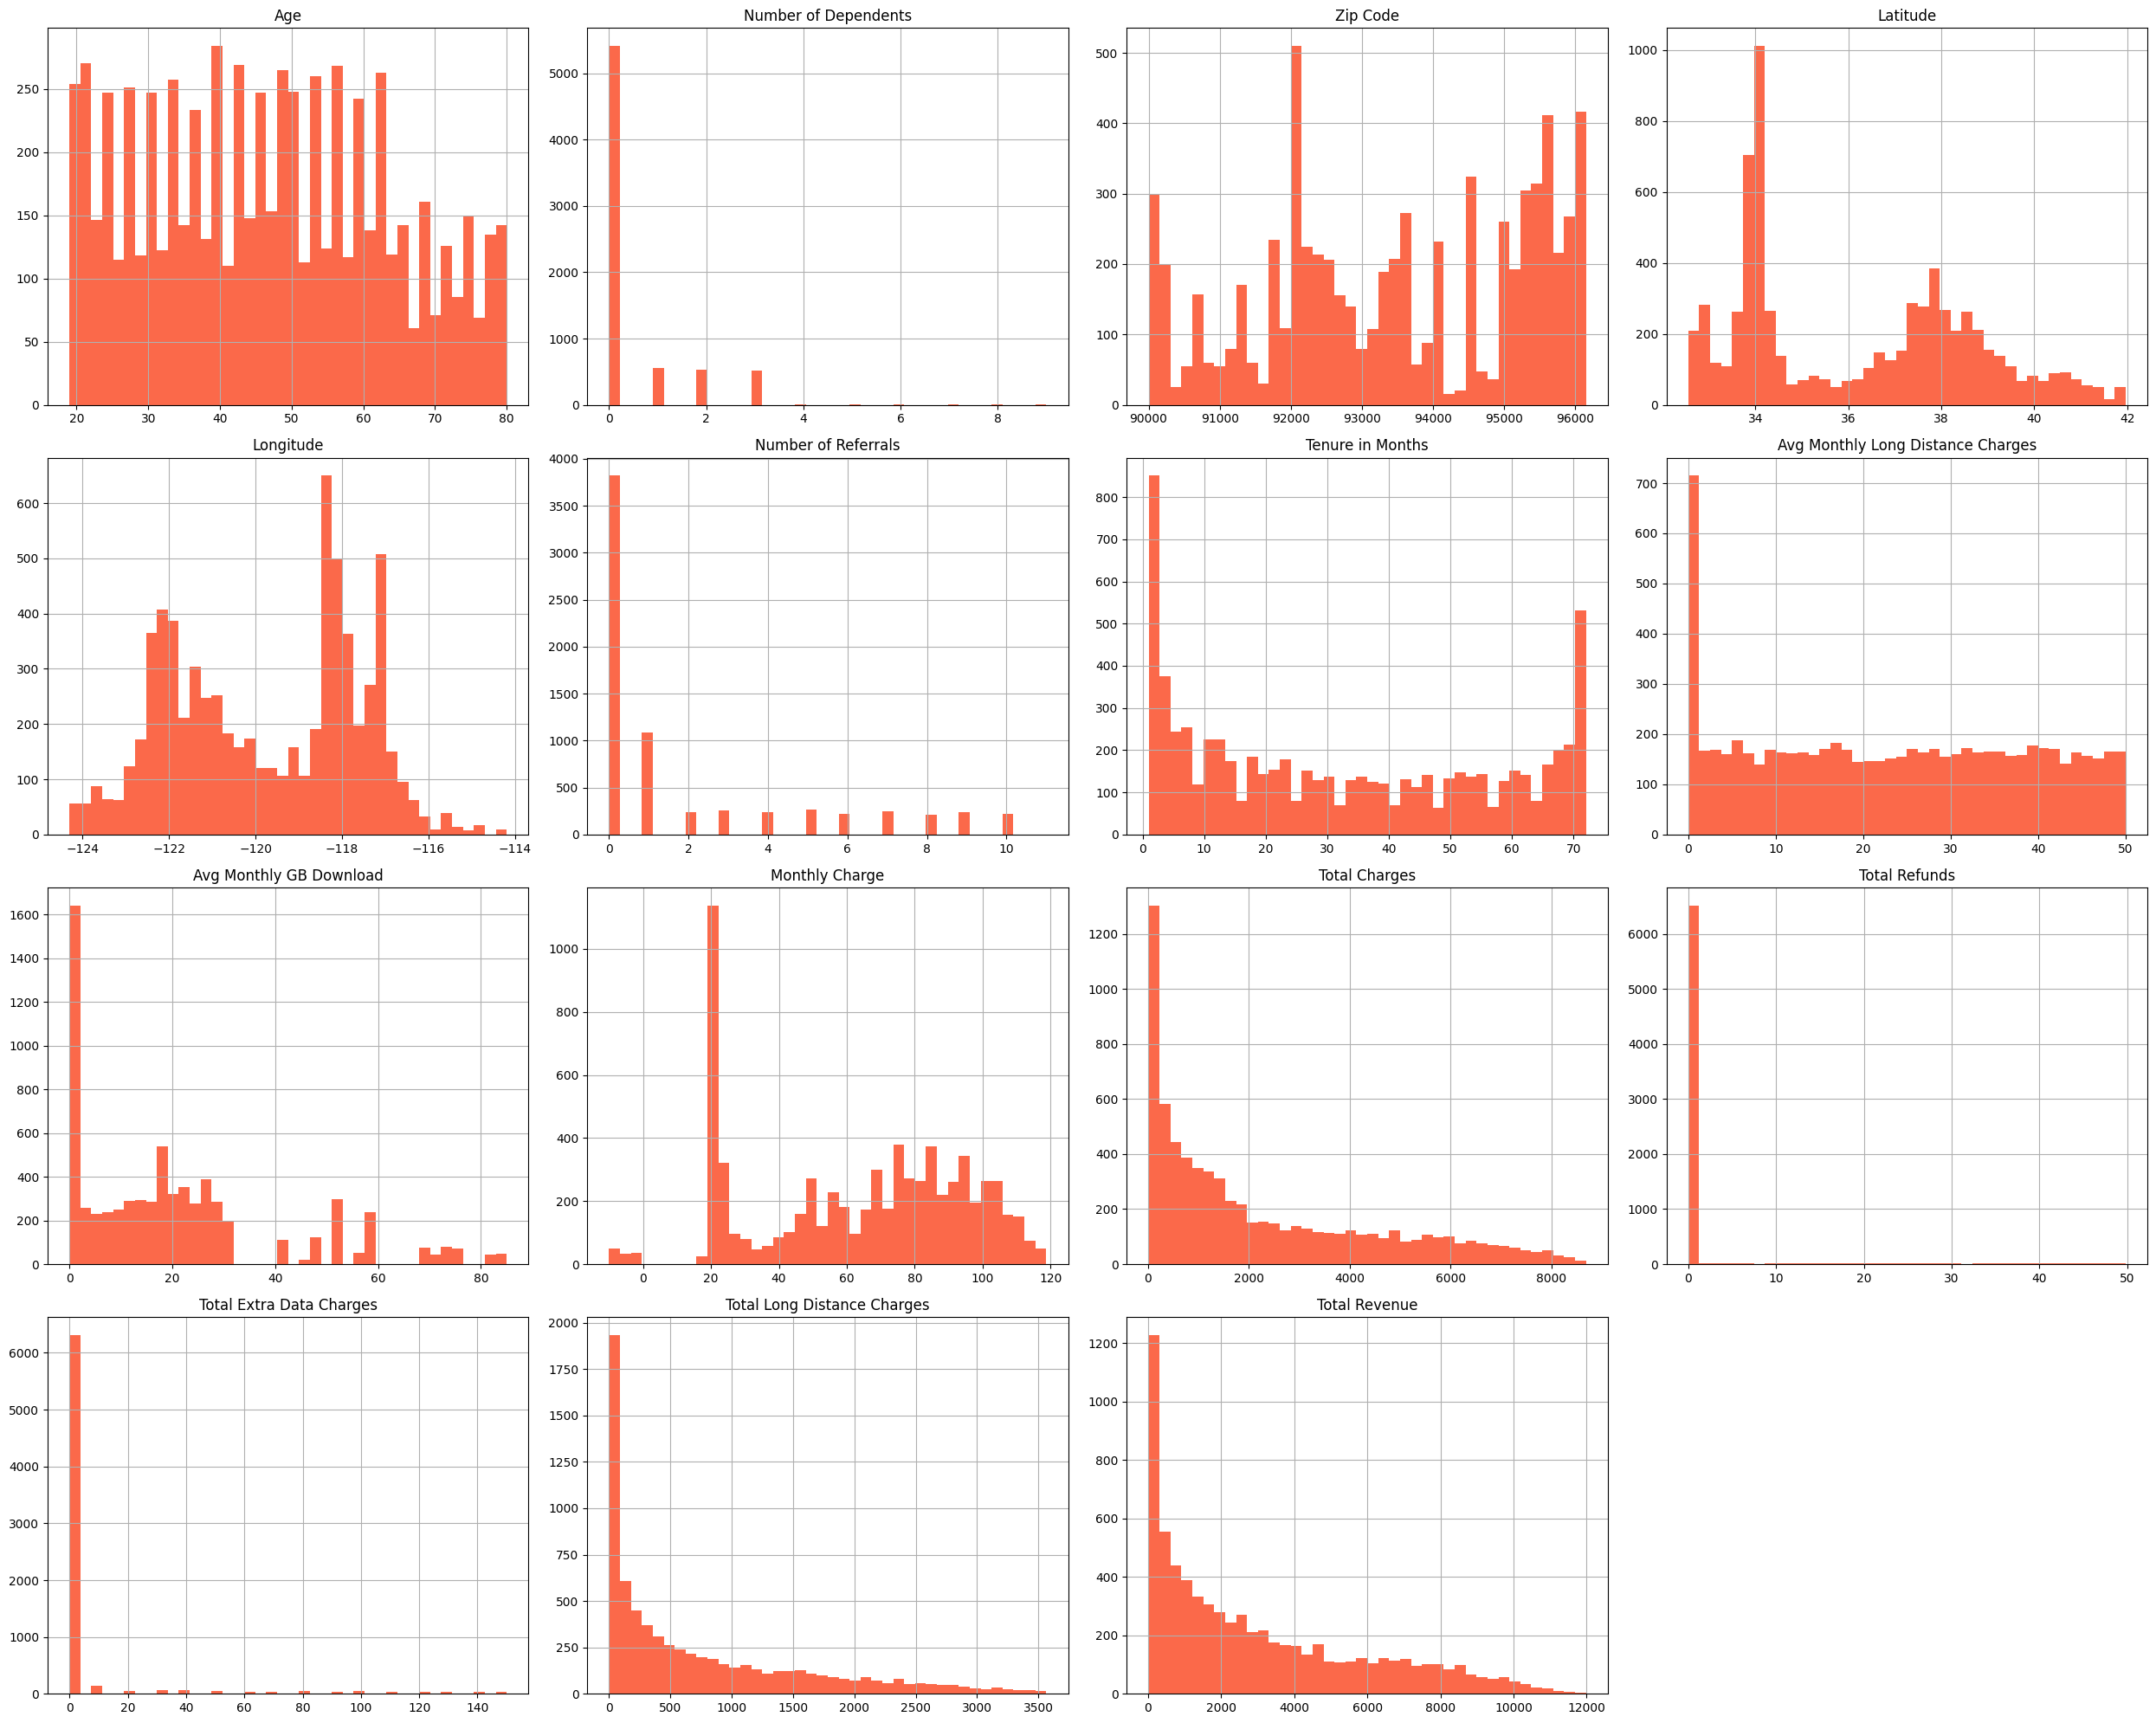

In [10]:
df.hist(
    bins=40,
    figsize=(25, 20), 
    color=sns.color_palette("Reds", 1)
)
plt.tight_layout()
plt.show()


From the numerical feature distributions, we notice several consistent patterns:

- **Tenure in Months** has a wide spread, with a concentration at lower tenures, suggesting many customers are relatively new.
- **Total Charges / Total Revenue** show strong right-skewness, as expected for accumulated billing variables.
- **Total Refunds** and **Total Extra Data Charges** are heavily concentrated near zero, meaning most customers do not frequently receive refunds or incur extra charges.

These findings are aligned with typical telecom churn datasets and motivate further analysis of churn relationships.

### Distribution of Categorical Features

Next, we visualize the distribution of key categorical features using count plots.

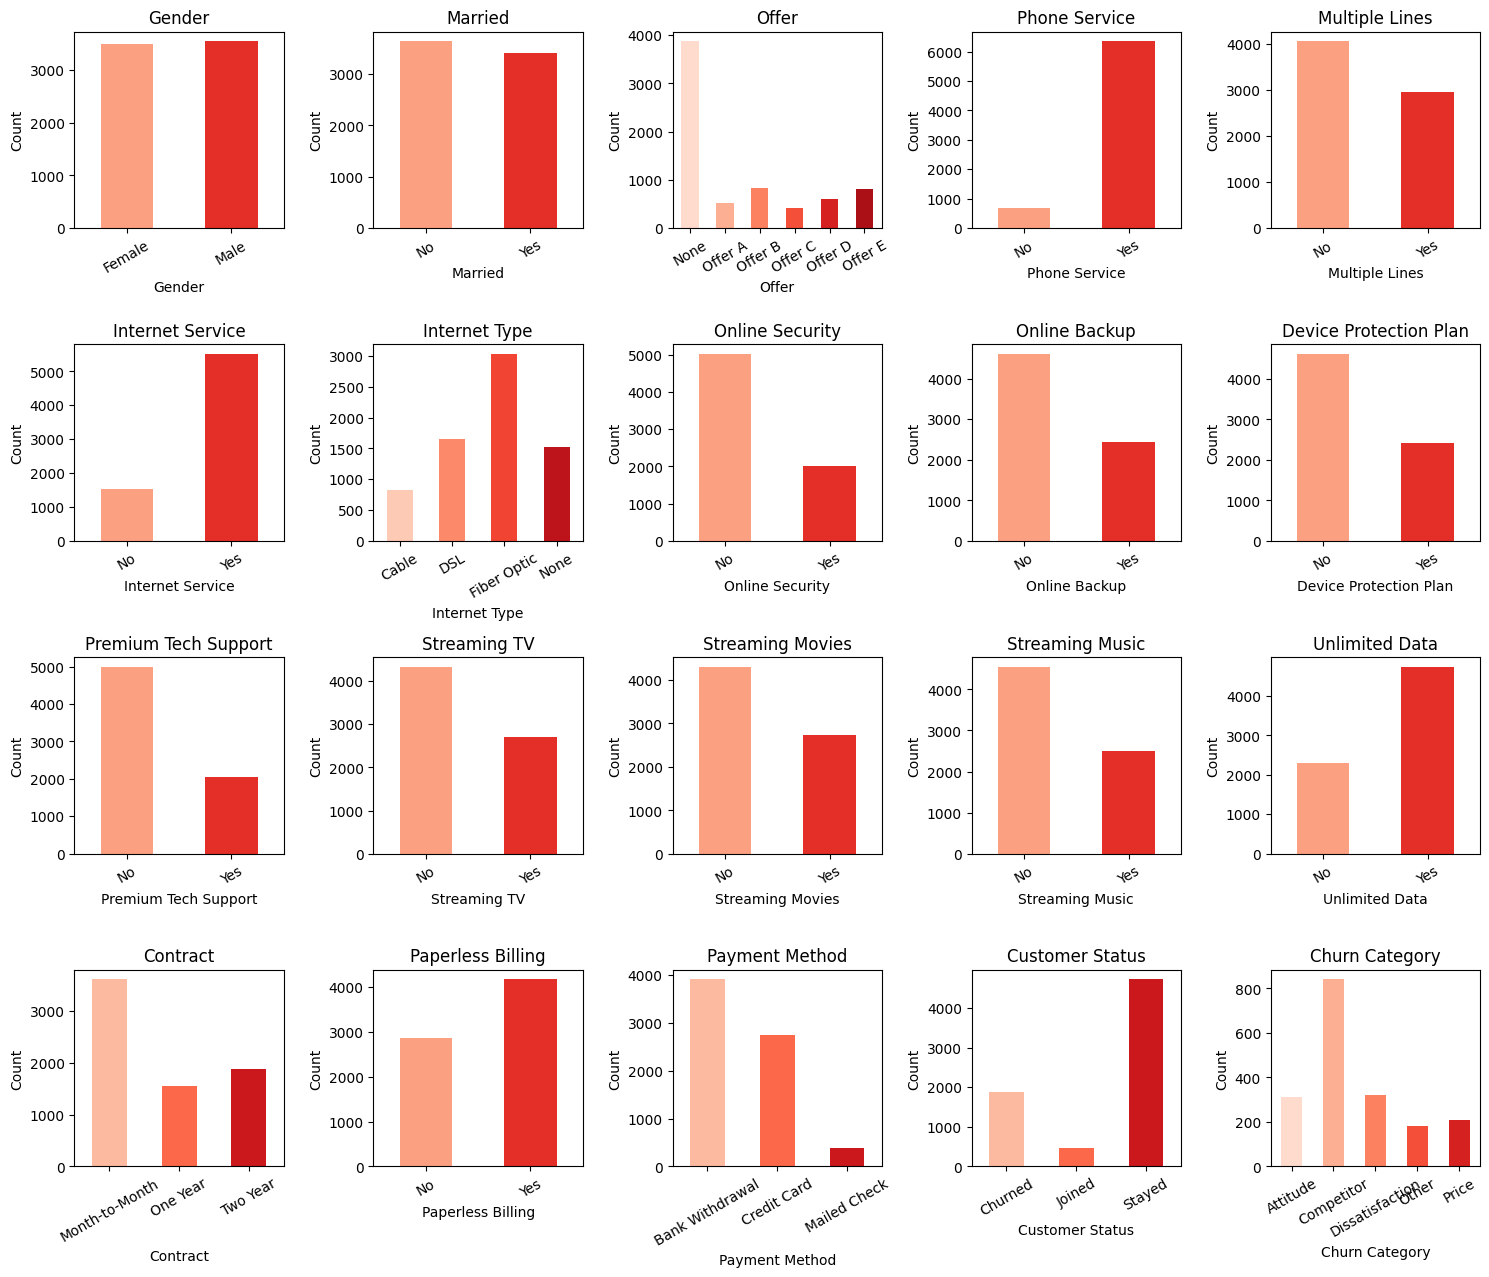

In [11]:
cat_cols = df.drop(columns = ["Customer ID", "City", "Churn Reason"]).select_dtypes(include="object").columns

ncols = 4
nrows = math.ceil(len(cat_cols) / ncols)

fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    df[col].value_counts().sort_index().plot(
        kind="bar",
        ax=axes[i],
        color=sns.color_palette("Reds", len(df[col].unique()))
    )

    axes[i].set_title(col)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis="x", rotation=30)

# remove unused plots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Several high-level patterns can be observed from the categorical distributions:

- **Month-to-month contracts** form the largest group.
- A large portion of customers have **Internet Service enabled**, with **Fiber Optic** appearing as a dominant internet type.
- Most internet add-on services (e.g., Online Security, Backup, Premium Tech Support) show higher counts for **"No"**, indicating add-ons are not widely adopted.
- **Paperless Billing** and **Bank Withdrawal/Credit Card payments** dominate customer billing behavior.

These patterns provide strong candidates for churn-related feature importance in later modeling stages.


### Correlation Heatmap Analysis
To better understand the relationships between numerical features, we visualize a correlation heatmap.  
This helps identify:

- **Strong correlations** (close to +1 or −1) → may indicate multicollinearity.
- **Weak correlations** (close to 0) → features are largely independent.
- **Redundant variables** → candidates for removal in linear models such as Logistic Regression.

Multicollinearity does not heavily affect tree-based models (Random Forest, XGBoost), but it can lead to unstable coefficients and reduced interpretability in Logistic Regression.  

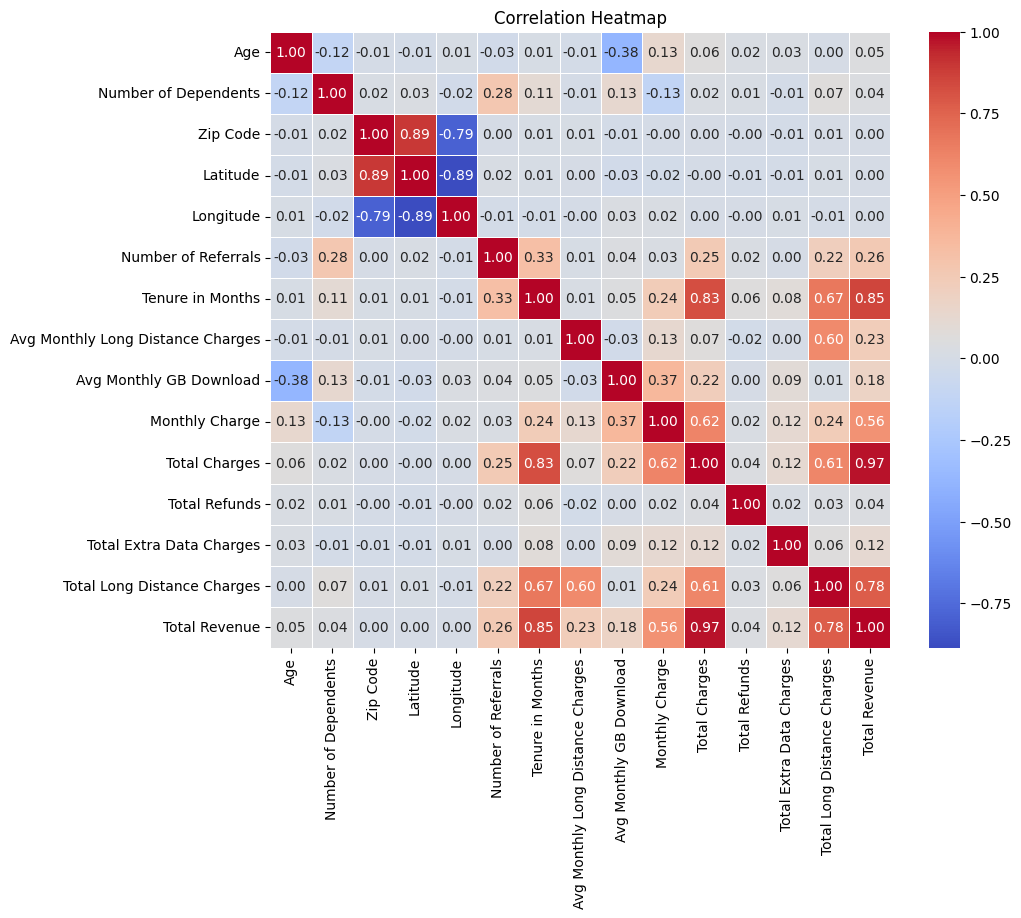

In [12]:
# select only numeric columns
corr = df.select_dtypes(include=['int64', 'float64']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,        # show numbers
    fmt=".2f",         # 2 decimal places
    cmap="coolwarm",   # color style
    linewidths=0.5
)

plt.title("Correlation Heatmap")
plt.show()


**Key Observations**

- Strong correlations appear among **Total Charges, Total Revenue, and Tenure**, indicating these variables carry overlapping information.
- **Monthly Charge** is moderately correlated with totals, suggesting it already captures most billing effects.
- Geographic variables (Zip Code, Latitude, Longitude) show high mutual correlation but weak relation to churn-related behaviour.


## Churn Reasons

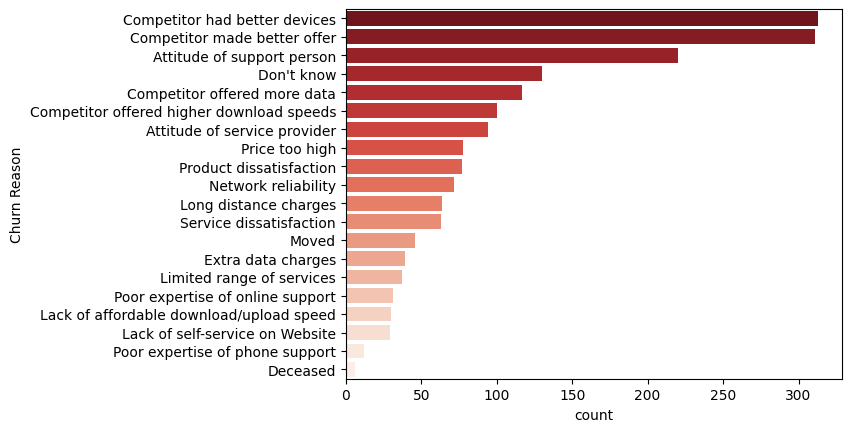

In [13]:
sns.countplot(
    data=df,
    y="Churn Reason",
    order=df["Churn Reason"].value_counts().index,
    palette="Reds_r"
)
plt.show()


The churn reason distribution shows that customers leave for different reasons. Many of them leave because of competitors, which means churn is not only caused by company problems but also by strong competition in the market.

Some common reasons:
- Competitors offering better deals or better devices  
- Bad customer support or service experience  
- Customers being unhappy with prices  
- Network problems or not liking the product  

These results suggest some ways to reduce churn, such as giving special offers to customers who might leave, improving customer service, and creating loyalty programs to keep customers interested.


### Customer Status 

The dataset defines **Customer Status** using three categories:

- **Joined**
- **Stayed**
- **Churned**

We first analyse what **Joined** means by visualizing the distribution of **Tenure in Months** for customers labeled as **Joined**.

<Axes: xlabel='Tenure in Months', ylabel='count'>

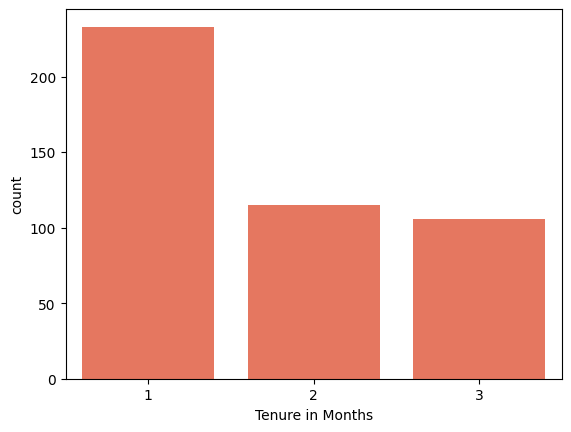

In [14]:
sns.countplot(df[df["Customer Status"] == "Joined"], x="Tenure in Months", color=sns.color_palette("Reds", 1)[0])

The tenure plot shows that customers marked as **Joined** are mostly very new customers (**less than 3 months tenure**).  
So this group is different from long-term customers.

We treat **Joined** customers as **Not Churned**, because they have not churned yet (they are still active in the current quarter).

So we create a binary target:

- `Churn = 1` → Churned  
- `Churn = 0` → Stayed or Joined  


Customer Status
Stayed     0.670169
Churned    0.265370
Joined     0.064461
Name: proportion, dtype: float64
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


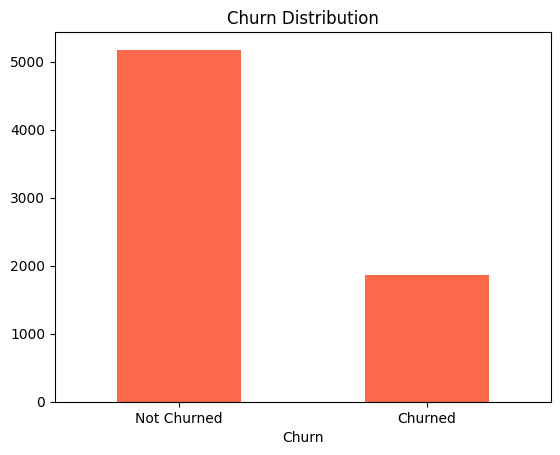

In [15]:
print(df["Customer Status"].value_counts(normalize=True))

df["Churn"] = df["Customer Status"].apply(lambda x: 1 if x == "Churned" else 0)

print(df["Churn"].value_counts(normalize=True))

df["Churn"].value_counts().plot(kind="bar", color=sns.color_palette("Reds", 1))
plt.title("Churn Distribution")
plt.xticks(rotation=0)
plt.gca().set_xticklabels(["Not Churned", "Churned"])
plt.show()

### Tenure vs Offer Type

We examine how **tenure differs across offer types** to check whether offers are targeted to different customer segments (e.g., new vs long-term customers).


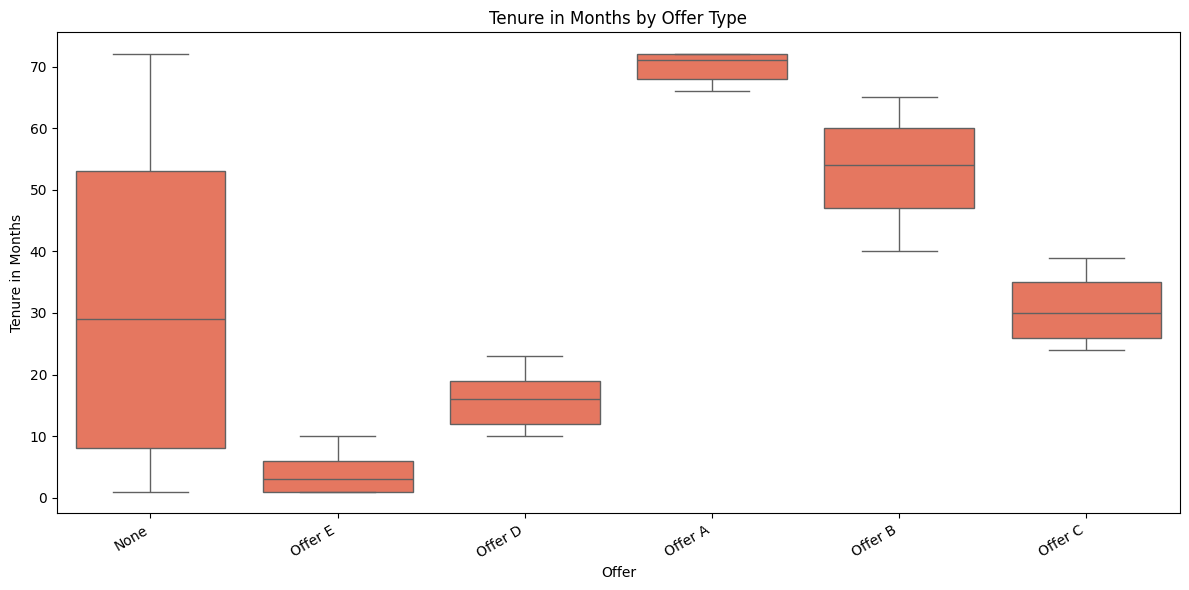

In [16]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x="Offer", y="Tenure in Months", color=sns.color_palette("Reds", 1)[0])
plt.xticks(rotation=30, ha="right")
plt.title("Tenure in Months by Offer Type")
plt.tight_layout()
plt.show()


 From the boxplots, offer types show very different tenure distributions. **Offer E** is mainly used by **new customers (low tenure)**, while **Offer A/B** are associated with **long-tenure customers**. 
 
 This suggests offers are linked to customer lifecycle segments, so offer-related churn patterns should be interpreted carefully.


### Relationship Between Features and Churn Rate

Here we check how churn rate changes across different customer groups (e.g. contract type, internet type, payment method).  
This helps us quickly see which categories are linked to higher churn.



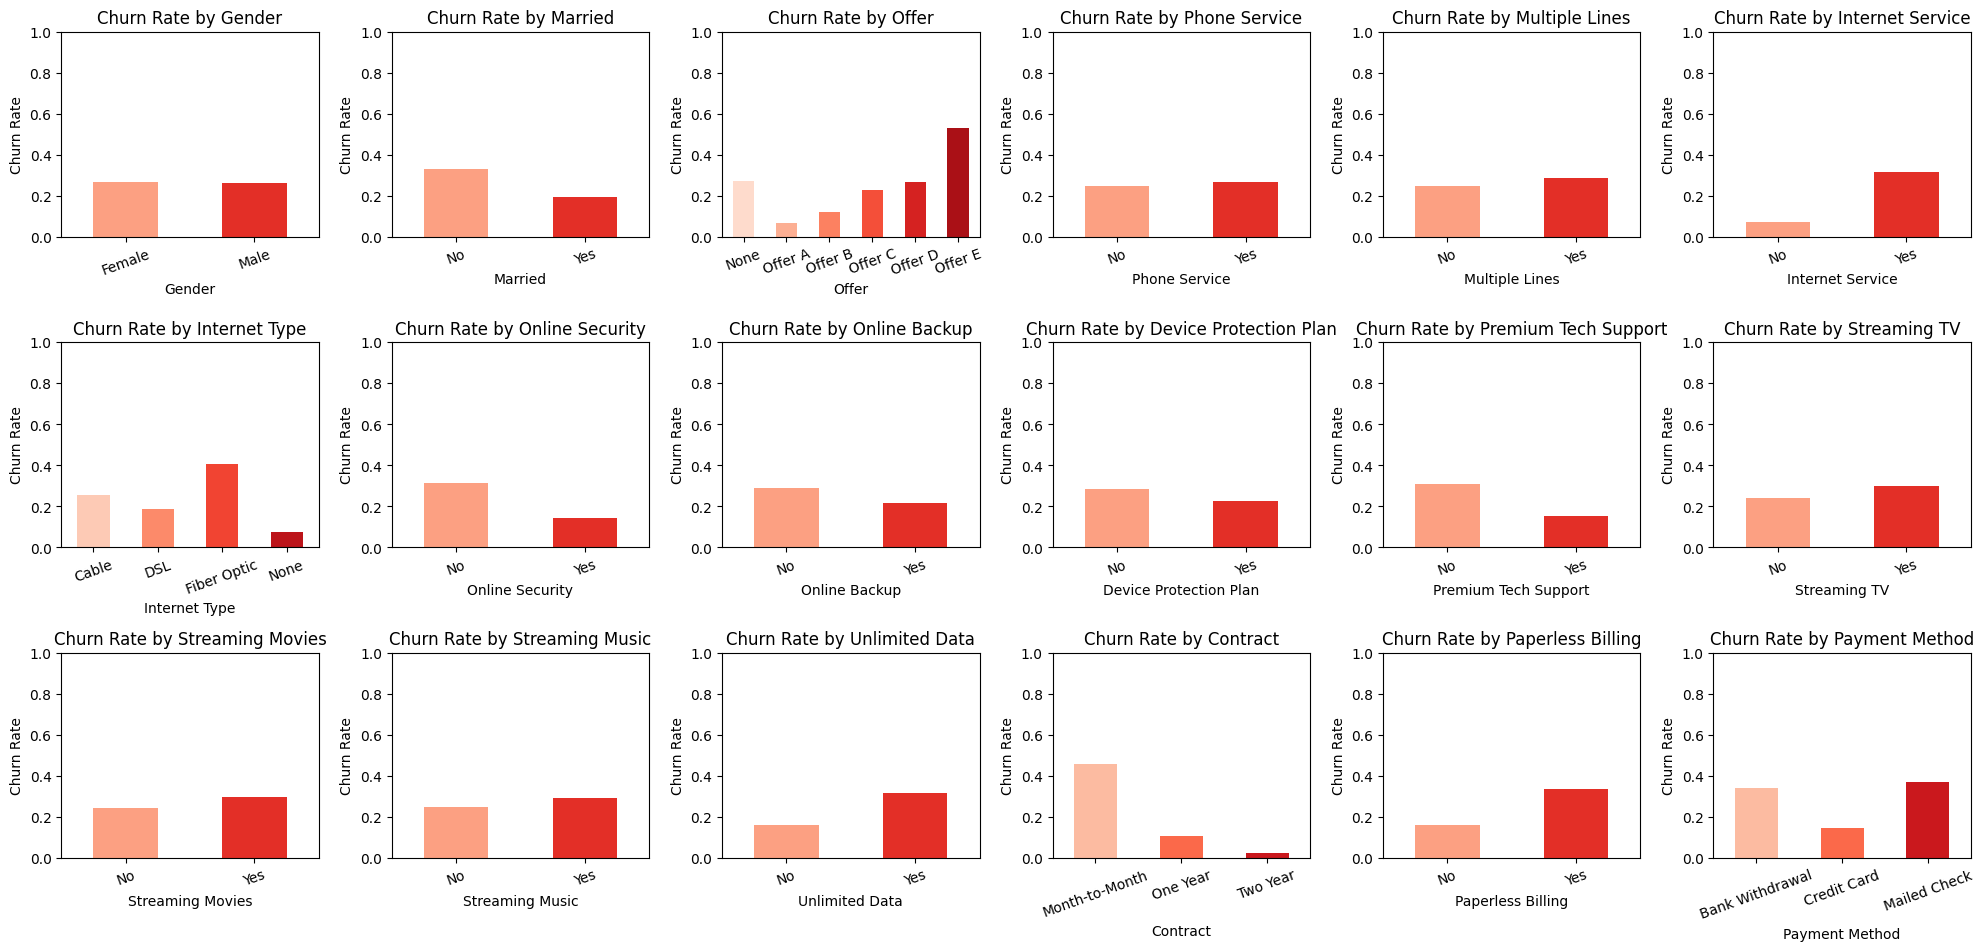

In [17]:
cat_cols = list(df.drop(columns=["Customer ID", "City", "Zip Code", "Latitude", "Longitude", "Churn Reason", "Customer Status", "Churn Category"]).select_dtypes(include="object").columns)


fig, axes = plt.subplots(5, 6, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    churn_rate = df.groupby(col)["Churn"].mean().sort_index()
    palette = sns.color_palette("Reds", len(churn_rate))

    churn_rate.plot(kind="bar", ax=axes[i], color=palette)

    axes[i].set_title(f"Churn Rate by {col}")
    axes[i].set_ylabel("Churn Rate")
    axes[i].set_ylim(0, 1)
    axes[i].tick_params(axis="x", rotation=20)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Quick Insights:

- **Month-to-month** customers churn the most.
- **Fiber Optic** users have higher churn than DSL / no internet.
- Customers without **security/backup/tech support** add-ons churn more.
- **Paperless billing** and some **payment methods** also show higher churn.

Next, we compare numeric features between churned and non-churned customers using boxplots.


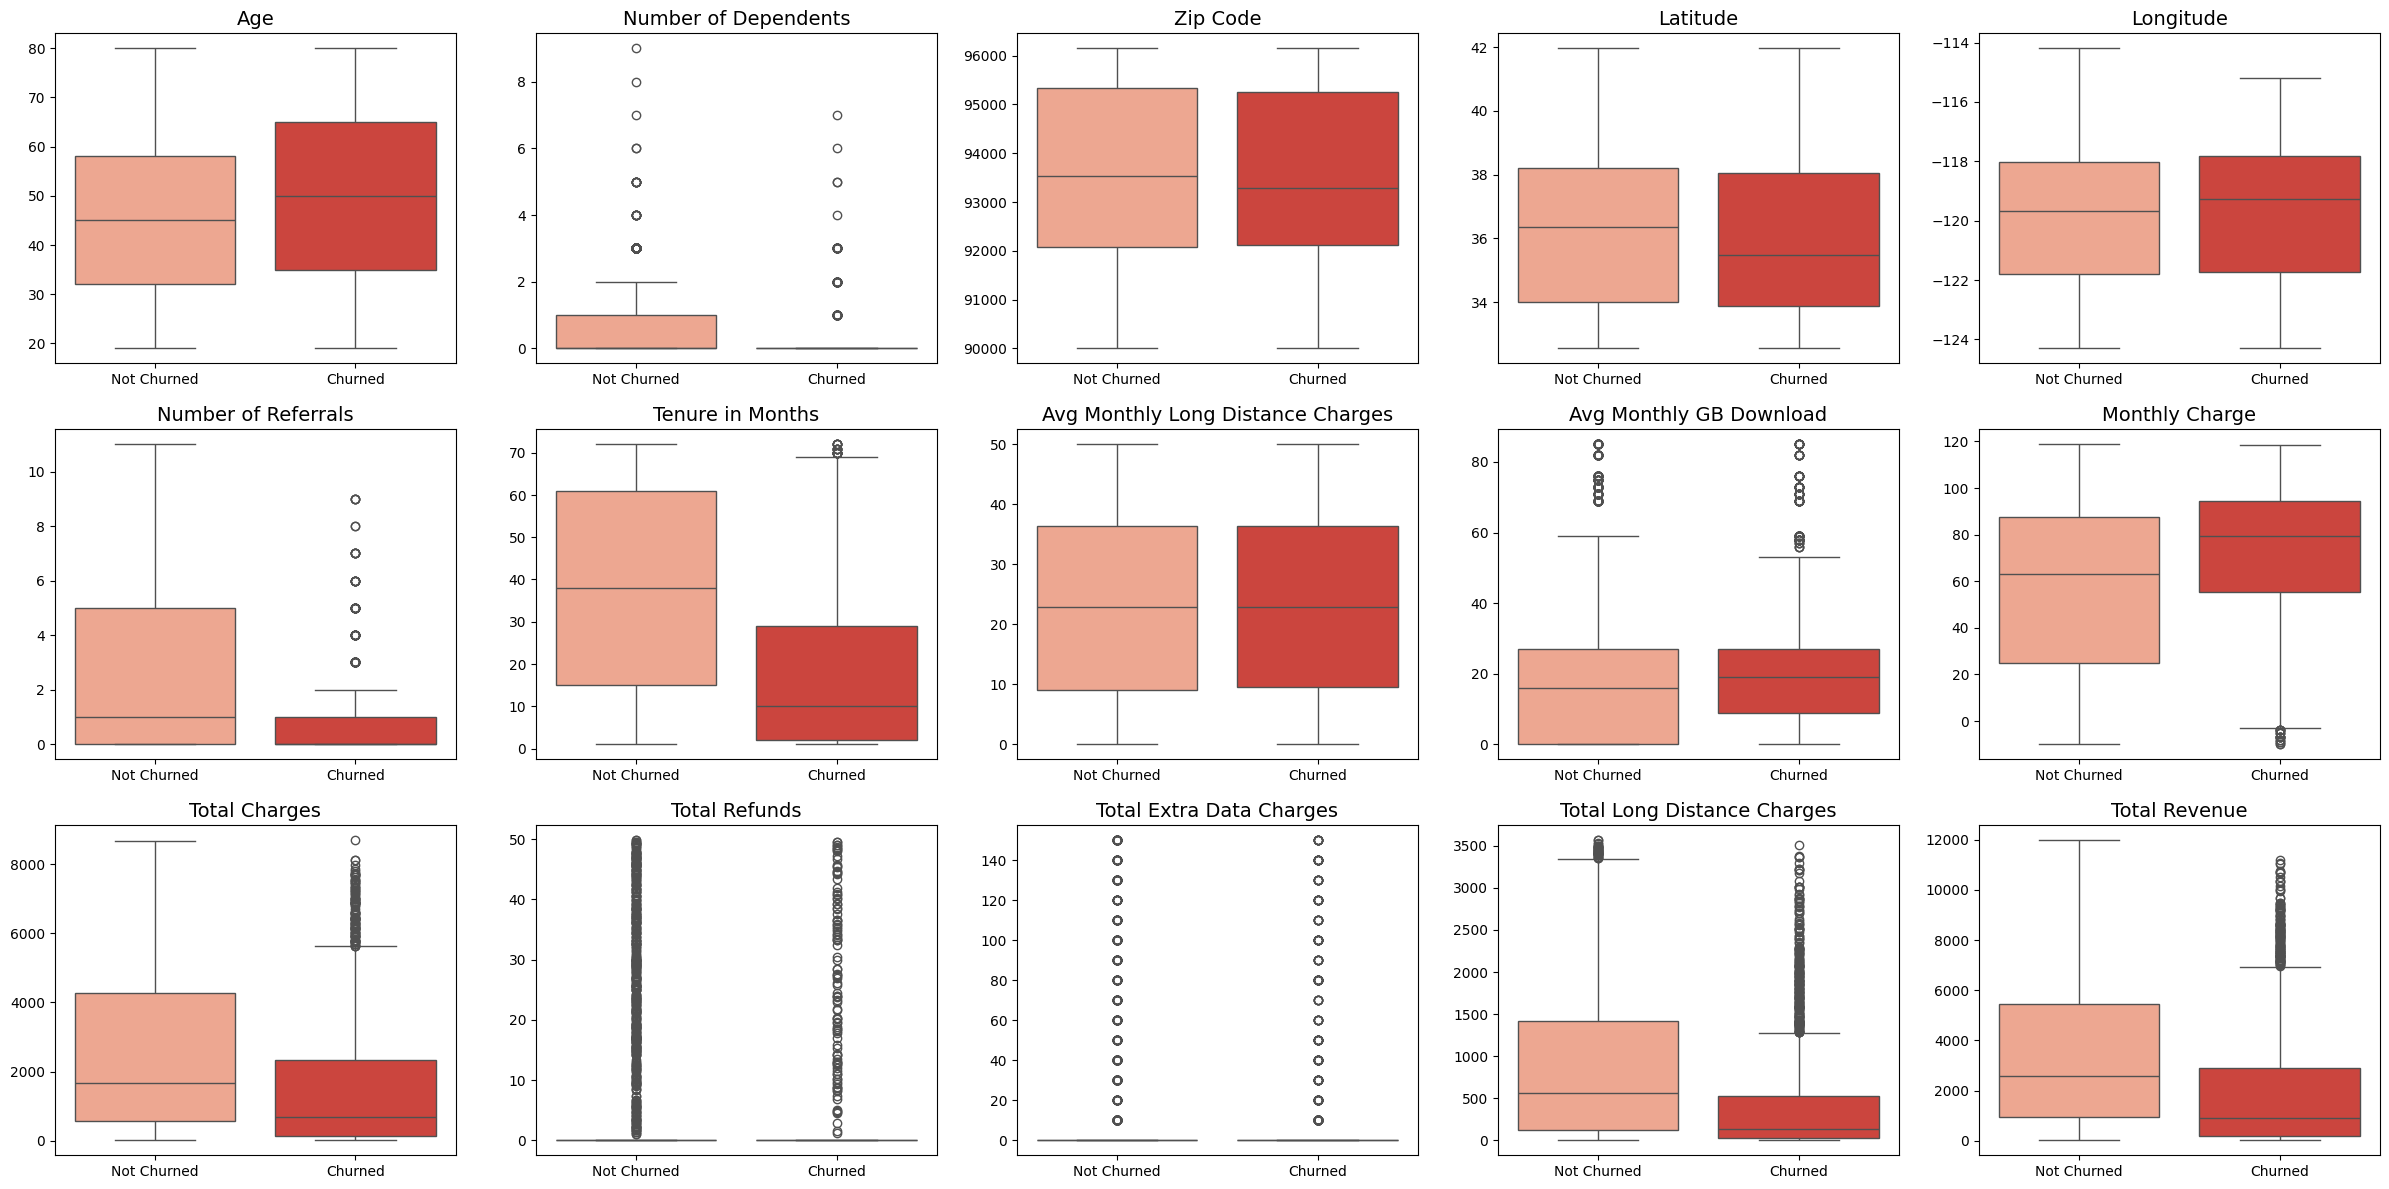

In [18]:
num_cols = [
    cname for cname in df.columns
    if df[cname].dtype in ["int64", "float64"]
    and cname != "Churn"
    and df[cname].nunique() > 2
]

fig, axes = plt.subplots(6, 5, figsize=(30, 30))
axes = axes.flatten()
color_palette = sns.color_palette("Reds", 2)
palette = {"0": color_palette[0], "1": color_palette[1]}

for i, col in enumerate(num_cols):
    ax = axes[i]

    sns.boxplot(
        data=df,
        x="Churn",
        y=col,
        ax=ax,
        palette=palette
    )

    ax.set_title(col, fontsize=14)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticklabels(["Not Churned", "Churned"])

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()


Quick Insights

- Churned customers usually have **shorter tenure**, so new users should be our target.
- Churned customers often have **higher monthly charges**.
- Total revenue/charges are lower for churned customers (because they leave earlier).
- Customers with more referrals tend to churn less.


## 4. Model Building


### Encoding Binary Features

Some columns are simple **Yes/No** values (like Phone Service, Online Security, Paperless Billing, etc.).  
To make them usable for machine learning, we convert:

- **Yes → 1**
- **No → 0**

We also encode Gender as:
- **Male → 1**
- **Female → 0**


In [19]:
yes_no_cols = [
    "Married", "Phone Service", "Multiple Lines", "Internet Service",
    "Online Security", "Online Backup", "Device Protection Plan",
    "Premium Tech Support", "Streaming TV", "Streaming Movies",
    "Streaming Music", "Unlimited Data", "Paperless Billing"
]

for col in yes_no_cols:
    df[col] = df[col].map({"Yes": 1, "No": 0})

df["Gender"] = df["Gender"].map({"Male": 1, "Female": 0})


## Feature Selection 

In this step, we remove columns that are **not useful for prediction** or may cause **data leakage** in the churn model.

- **Customer ID** → purely an identifier, no predictive value.  
- **Churn Category & Churn Reason** → directly reveal why a customer left, which would leak the answer to the model.  
- **Customer Status** → contains the churn outcome itself (Churned / Stayed / Joined), so it must be removed.  
- **Zip Code, Longitude, Latitude, City** → geographic information that is highly correlated and adds little value for logistic regression while increasing dimensionality.




In [20]:
df_filtered = df.drop(columns=['Customer ID','Churn Category','Churn Reason','Zip Code','Longitude','Latitude','City', "Customer Status"])

X = df_filtered.drop(columns=["Churn"])
y = df_filtered["Churn"]

In [21]:
# selected_features = [
#     # Loyalty
#     "Tenure in Months", "Number of Referrals",

#     # Contract & billing
#     "Contract", "Paperless Billing", "Payment Method", "Offer",

#     # Pricing
#     "Monthly Charge", "Internet Service", "Internet Type",
#     "Online Security", "Premium Tech Support",
#     "Unlimited Data", "Online Backup", "Device Protection Plan",
# ]

# # selected_features = [
# #     "Contract", "Offer",   # Contract & Offer
# #     "Monthly Charge", "Internet Type", # Pricing
# #     "Online Security", "Premium Tech Support",
# #     "Unlimited Data", "Online Backup", "Device Protection Plan",  # Add-on Services
# #     "Paperless Billing", "Payment Method"  # Billing & Payment
# # ]

# X = df[selected_features]
# y = df["Churn"]



We split the dataset into training and testing sets: **80% training**, **20% testing**

We use `stratify=y` to keep the churn ratio similar in both sets, since churn is slightly imbalanced.


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


### Pre-Processing
Our dataset contains different feature types:

- **Numerical** (Monthly Charge) → scaled using `StandardScaler`
- **Categorical** (Contract, Payment Method, Internet Type, Offer) → one-hot encoded
- **Binary** (Yes/No columns) → already encoded as 0/1, so we keep them

We put all preprocessing + the model into one `Pipeline`, so the workflow is clean and prevents data leakage

In [23]:
num_cols = [
    "Monthly Charge",
    "Total Charges",
    "Total Revenue",
    "Total Long Distance Charges",
    "Total Extra Data Charges",
    "Age",
    "Tenure in Months",
    "Avg Monthly GB Download",
    "Avg Monthly Long Distance Charges",
    "Number of Dependents",
    "Number of Referrals",
    "Total Refunds"
]

cat_cols = [
    "Contract",
    "Payment Method",
    "Internet Type",
    "Offer"
]

bin_cols = [c for c in X.columns if c not in num_cols + cat_cols]

In [24]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop=None, handle_unknown="ignore"), cat_cols),
        ("bin", "passthrough", bin_cols)
    ]
)

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000))  # better for interpretability
])

### 4.1. Logistic Regression
#### Hyperparameter Tuning (Grid Search)

We used **GridSearchCV (5-fold CV)** to tune Logistic Regression hyperparameters, using **ROC-AUC** as the scoring metric (good for imbalanced datasets like churn).

We test:
- different **C values** (regularization strength)
- **L1 vs L2 penalty**
- using `class_weight="balanced"` vs None

**Note**: We used **ROC-AUC** as the scoring metric here because ROC-AUC measures how well the model can **rank churn customers higher than non-churn customers**, and it does **not depend on a fixed classification threshold** (e.g., 0.5) 
This makes ROC-AUC a reliable metric for comparing different hyperparameter settings during cross-validation, especially for moderately imbalanced datasets like churn.


In [25]:
param_grid = {
    "model__C": [0.01, 0.1, 1, 5, 10, 100],
    "model__penalty": ["l1", "l2"],
    "model__class_weight": [None, "balanced"]
}

lr_gs = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring="roc_auc",  # good for imbalanced data
    cv=5,
    n_jobs=-1,
    verbose=1
)

lr_gs.fit(X_train, y_train)

print("\nBest parameters:", lr_gs.best_params_)
print("Best CV ROC-AUC:", lr_gs.best_score_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters: {'model__C': 1, 'model__class_weight': None, 'model__penalty': 'l2'}
Best CV ROC-AUC: 0.8976916250772607


From the result, here is our best model:
- **Total fits:** 100 (20 parameter combinations × 5 folds)
- **Best parameters:**
  - `C = 1`
  - `penalty = l2`
  - `class_weight = None`
- **Best CV ROC-AUC:** **0.898**

This means our tuned logistic regression model can separate churn vs non-churn fairly well based on the selected features.

After selecting the best model, we evaluate it on the **test set** to check how well it generalizes to unseen data.


### Threshold Tuning
By default, Logistic Regression uses a threshold of **0.5** to classify churn. However, with imbalanced data, **0.5 may miss too many churn cases**.

So we tested thresholds from **0.05 → 0.95** and selected the one with the **highest F1-score**.

**Note**: We use **F1-score** because the final classification decision depends on the chosen probability threshold.  
F1-score balances **precision** and **recall**, which is important in churn prediction: we want to catch churners (high recall) while avoiding too many false alarms (reasonable precision).



In [26]:
best_lr = lr_gs.best_estimator_
y_proba_lr = best_lr.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.05, 0.96, 0.05)

best_t_lr = 0
best_f1_lr = 0

for t in thresholds:
    y_pred_t = (y_proba_lr >= t).astype(int)
    f1 = f1_score(y_test, y_pred_t)
    if f1 > best_f1_lr:
        best_f1_lr = f1
        best_t_lr = t

print("Best threshold for F1:", best_t_lr)
print("Best F1:", best_f1_lr)

y_pred_best_lr = (y_proba_lr >= best_t_lr).astype(int)
print(classification_report(y_test, y_pred_best_lr))

Best threshold for F1: 0.30000000000000004
Best F1: 0.6777041942604857
              precision    recall  f1-score   support

           0       0.92      0.78      0.85      1035
           1       0.58      0.82      0.68       374

    accuracy                           0.79      1409
   macro avg       0.75      0.80      0.76      1409
weighted avg       0.83      0.79      0.80      1409



This threshold improves churn detection (high recall = 0.80), meaning we catch more churn customers, even though it may predict some extra false churn cases

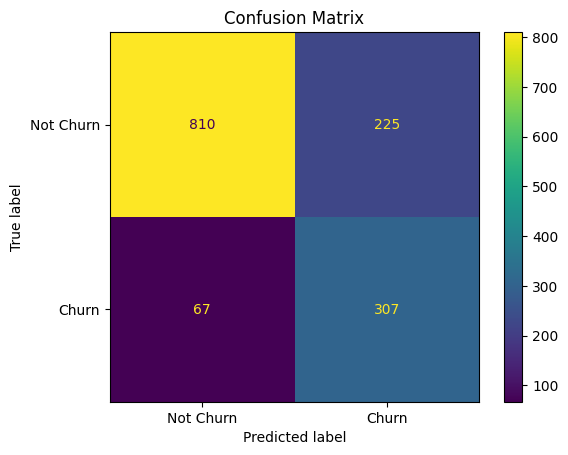

In [27]:
cm = confusion_matrix(y_test, y_pred_best_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Churn", "Churn"])
disp.plot(values_format="d")
plt.title("Confusion Matrix")
plt.show()


### Coefficients

After training the Logistic Regression model, we looked at the learned **coefficients** to understand which features increase or decrease churn risk.


In [28]:
feature_names = best_lr.named_steps["preprocess"].get_feature_names_out()
coefficients = best_lr.named_steps["model"].coef_[0]

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", ascending=False)

coef_df


,Feature,Coefficient
29,bin__Married,1.599252
12,cat__Contract_Month-to-Month,1.290939
23,cat__Offer_Offer A,0.574108
17,cat__Payment Method_Mailed Check,0.470220
0,num__Monthly Charge,0.414871
1,num__Total Charges,0.360910
39,bin__Streaming Music,0.342270
41,bin__Paperless Billing,0.336210
5,num__Age,0.298745
2,num__Total Revenue,0.270495


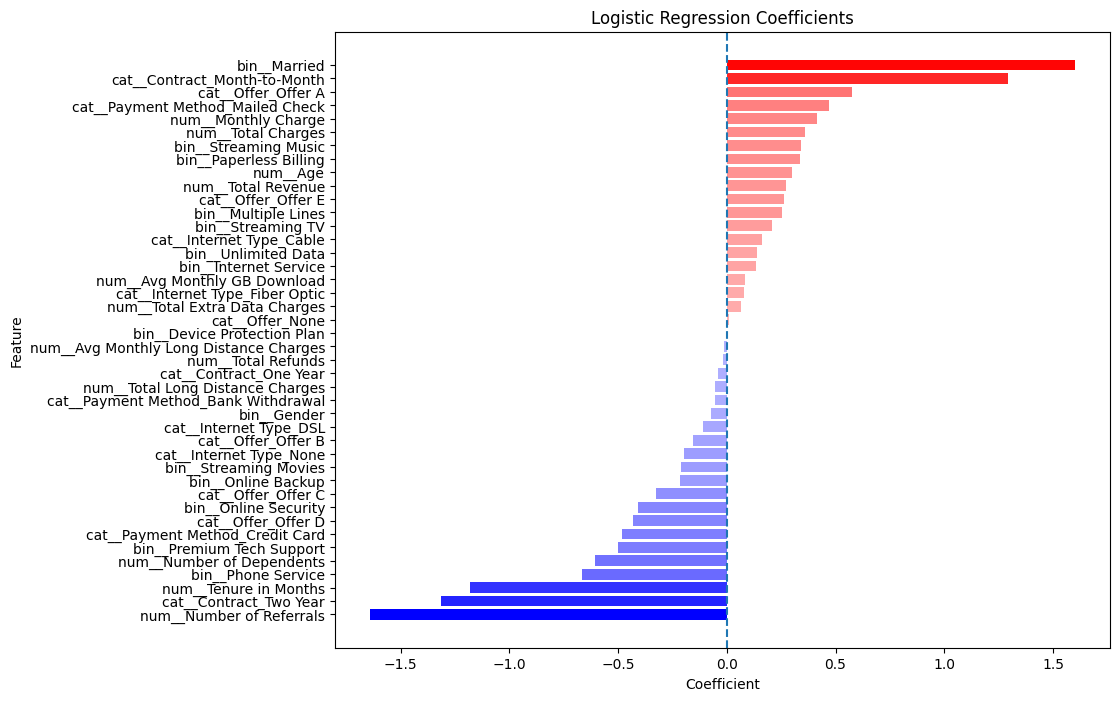

In [29]:
vals = coef_df["Coefficient"].values
abs_vals = np.abs(vals)

norm = plt.Normalize(abs_vals.min(), abs_vals.max())

colors = []
for v in vals:
    intensity = norm(abs(v))
    if v >= 0:
        colors.append(mcolors.to_rgba("red", alpha=0.3 + 0.7 * intensity))
    else:
        colors.append(mcolors.to_rgba("blue", alpha=0.3 + 0.7 * intensity))

plt.figure(figsize=(10, 8))
plt.barh(coef_df["Feature"], coef_df["Coefficient"], color=colors)


plt.axvline(0, linestyle="--")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.title(f"Logistic Regression Coefficients")
plt.gca().invert_yaxis()
plt.show()

Overall, the model suggests churn is mainly driven by:
- **Short-term contracts (Month-to-Month)**
- **Higher monthly price**
- **Mailed Check payment method**
- **Certain offer groups (especially Offer E)**

And churn is reduced by:
- **Long-term contracts (Two Year / One Year)**
- **Extra services like Online Security and Premium Tech Support**
- **More stable payment methods (Credit Card / Bank Withdrawal)**

These patterns also match what we observed earlier during EDA.

### 4.2. Random Forests

We also tried a **Random Forest**, which is an ensemble of decision trees that can capture non-linear relationships and feature interactions.

We built a pipeline with:
- **OneHotEncoder** for categorical features (`Contract`, `Payment Method`, `Internet Type`, `Offer`)
- **Passthrough** for numeric + binary features
- **RandomForestClassifier**



In [30]:
preprocess_tree = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("bin_num", "passthrough", bin_cols + num_cols),
    ],
    remainder="drop"
)


### Hyperparameter tuning (RandomizedSearchCV)
We tuned the Random Forest using **RandomizedSearchCV** with:
- `scoring = "roc_auc"`
- `cv = 3`
- `n_iter = 80`


In [31]:
rf_pipe = Pipeline(steps=[
    ("preprocess", preprocess_tree),
    ("model", RandomForestClassifier(
        random_state=42,
        n_jobs=-1
    ))
])

rf_param_dist = {
    "model__n_estimators": randint(200, 500),         
    "model__max_depth": [None, 6, 10, 14, 18],
    "model__min_samples_split": randint(2, 50),
    "model__min_samples_leaf": randint(1, 30),
    "model__max_features": ["sqrt", "log2", 0.5],
    "model__class_weight": [None, "balanced"]
}

rf_rs = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=rf_param_dist,
    n_iter=80,             
    scoring="roc_auc",
    cv=3,                   
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rf_rs.fit(X_train, y_train)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'model__class_weight': [None, 'balanced'], 'model__max_depth': [None, 6, ...], 'model__max_features': ['sqrt', 'log2', ...], 'model__min_samples_leaf': <scipy.stats....t 0x151424b90>, ...}"
,n_iter,80
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [32]:
print("Best AUC (CV):", rf_rs.best_score_)
print("Best params:", rf_rs.best_params_)

best_rf = rf_rs.best_estimator_
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba_rf))

Best AUC (CV): 0.9017752329591165
Best params: {'model__class_weight': 'balanced', 'model__max_depth': 18, 'model__max_features': 0.5, 'model__min_samples_leaf': 7, 'model__min_samples_split': 33, 'model__n_estimators': 421}
Test ROC-AUC: 0.8979797979797979


From the result, we found that best parameters would be:
- `n_estimators = 271`
- `max_depth = 14`
- `max_features = sqrt`
- `min_samples_split = 44`
- `min_samples_leaf = 15`
- `class_weight = None`

In [33]:
# # Tune threshold for recall with precision constraint
# y_proba_rf = best_rf.predict_proba(X_test)[:, 1]
# thresholds = np.arange(0.05, 0.95, 0.01)

# min_precision = 0.60  # change to 0.5 if you want more recall

# best_t_rf = 0.5
# best_recall_rf = 0

# for t in thresholds:
#     y_pred_t = (y_proba_rf >= t).astype(int)
#     p = precision_score(y_test, y_pred_t)
#     r = recall_score(y_test, y_pred_t)

#     if p >= min_precision and r > best_recall_rf:
#         best_recall_rf = r
#         best_t_rf = t

# print("Best threshold (Recall-focused):", best_t_rf)
# print("Best recall (Precision >= {:.2f}): {:.3f}".format(min_precision, best_recall_rf))

# y_pred_best_rf = (y_proba_rf >= best_t_rf).astype(int)

# print("\nClassification Report (Best Threshold):")
# print(classification_report(y_test, y_pred_best_rf))

# print(confusion_matrix(y_test, y_pred_best_rf))

Since churn is imbalanced, we tuned the decision threshold to improve our model. We tested thresholds from **0.05 → 0.95** and selected the one with the **highest F1-score**.


In [34]:
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba_rf))

thresholds = np.arange(0.05, 0.95, 0.05)

best_t_rf = 0.5
best_f1_rf = 0

for t in thresholds:
    y_pred_t = (y_proba_rf >= t).astype(int)
    score = f1_score(y_test, y_pred_t)
    if score > best_f1_rf:
        best_f1_rf = score
        best_t_rf = t

print("Best Threshold:", best_t_rf)
print("Best F1:", best_f1_rf)

y_pred_best_rf = (y_proba_rf >= best_t_rf).astype(int)

print("\nClassification Report (Best Threshold):")
print(classification_report(y_test, y_pred_best_rf))

Test ROC-AUC: 0.8979797979797979
Best Threshold: 0.55
Best F1: 0.6985294117647058

Classification Report (Best Threshold):
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      1035
           1       0.64      0.76      0.70       374

    accuracy                           0.83      1409
   macro avg       0.78      0.81      0.79      1409
weighted avg       0.84      0.83      0.83      1409



This threshold increases recall for churn customers, meaning we catch more real churn cases.


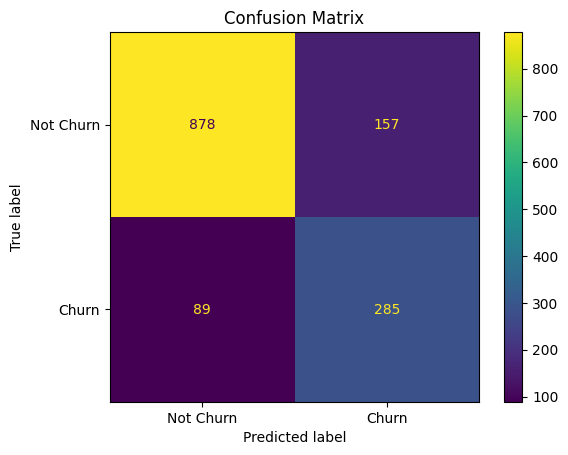

In [35]:
cm = confusion_matrix(y_test, y_pred_best_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Churn", "Churn"])
disp.plot(values_format="d")
plt.title("Confusion Matrix")
plt.show()


In [36]:
# get trained RF model from pipeline
rf_model = best_rf.named_steps["model"]

# get feature names after preprocessing
feature_names = best_rf.named_steps["preprocess"].get_feature_names_out()

importances = rf_model.feature_importances_

feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

feat_imp


,feature,importance
0,cat__Contract_Month-to-Month,0.291997
40,bin_num__Number of Referrals,0.125938
2,cat__Contract_Two Year,0.090397
30,bin_num__Monthly Charge,0.067162
39,bin_num__Number of Dependents,0.052176
36,bin_num__Tenure in Months,0.050739
35,bin_num__Age,0.045900
32,bin_num__Total Revenue,0.033203
31,bin_num__Total Charges,0.030329
33,bin_num__Total Long Distance Charges,0.028078


Most important features in the Random Forest were:
- **Contract = Month-to-Month** (strongest signal)
- **Monthly Charge**
- **Contract = Two Year / One Year**
- **Offer (especially Offer E)**
- **Internet Type (Fiber Optic)**
- **Online Security / Premium Tech Support**

Overall, these match the trend we saw earlier in EDA: customers with short contracts and higher charges are more likely to churn.

### 4.3. XGBoost


For the final model, we trained **XGBoost**, which is a boosted tree model that builds trees **sequentially**.  
Each new tree focuses more on the mistakes made by the previous trees, so the overall model becomes stronger over time.

### Model setup
We used the same preprocessing pipeline as Random Forest:
- **OneHotEncoder** for categorical features  
- **Pass-through** for binary + numeric features  
- Train/test split kept the same

In [37]:
xgb_pipe = Pipeline(steps=[
    ("preprocess", preprocess_tree),
    ("model", XGBClassifier(random_state=42, n_jobs=-1))
])

xgb_pipe.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('bin_num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


We tuned the model using **3-fold cross-validation** with **ROC-AUC** as the scoring metric.


In [38]:
xgb_pipe = Pipeline(steps=[
    ("preprocess", preprocess_tree),
    ("model", XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    ))
])

xgb_param_dist = {
    "model__n_estimators": randint(200, 900),
    "model__learning_rate": uniform(0.02, 0.18),   
    "model__max_depth": randint(2, 8),
    "model__min_child_weight": randint(1, 12),
    "model__subsample": uniform(0.6, 0.4),         
    "model__colsample_bytree": uniform(0.6, 0.4), 
    "model__gamma": uniform(0.0, 0.6),
    "model__reg_alpha": uniform(0.0, 0.5),
    "model__reg_lambda": uniform(0.5, 2.0),
}

xgb_rs = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=xgb_param_dist,
    n_iter=80,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

xgb_rs.fit(X_train, y_train)

print("Best CV AUC:", xgb_rs.best_score_)
print("Best params:", xgb_rs.best_params_)
best_xgb = xgb_rs.best_estimator_


Fitting 3 folds for each of 80 candidates, totalling 240 fits
Best CV AUC: 0.9102209257057438
Best params: {'model__colsample_bytree': np.float64(0.8211572356285312), 'model__gamma': np.float64(0.3556180343276361), 'model__learning_rate': np.float64(0.034553598739888745), 'model__max_depth': 4, 'model__min_child_weight': 1, 'model__n_estimators': 493, 'model__reg_alpha': np.float64(0.1838915663596266), 'model__reg_lambda': np.float64(1.764611661187159), 'model__subsample': np.float64(0.8534118843043579)}


In [39]:
y_proba_xg = best_xgb.predict_proba(X_test)[:, 1]
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba_xg))

Test ROC-AUC: 0.9040972383683382


Best parameters found:
- `n_estimators = 602`
- `max_depth = 2`
- `learning_rate = 0.0259`
- `subsample = 0.779`
- `colsample_bytree = 0.991`
- `gamma = 0.247`
- `min_child_weight = 1`
- `reg_alpha = 0.340`
- `reg_lambda = 1.562`

As before, we tune our threshold to achieve highest F1-Score


In [40]:
thresholds = np.arange(0.05, 0.95, 0.05)

best_t_xg = 0.5
best_f1_xg = 0

for t in thresholds:
    y_pred_t = (y_proba_xg >= t).astype(int)
    score = f1_score(y_test, y_pred_t)
    if score > best_f1_xg:
        best_f1_xg = score
        best_t_xg = t

print("Best Threshold:", best_t_xg)
print("Best F1:", best_f1_xg)

Best Threshold: 0.30000000000000004
Best F1: 0.7124563445867288


In [41]:
y_pred_best_xg = (y_proba_xg >= best_t_xg).astype(int)

print("\nClassification Report (Best Threshold):")
print(classification_report(y_test, y_pred_best_xg))


Classification Report (Best Threshold):
              precision    recall  f1-score   support

           0       0.93      0.83      0.87      1035
           1       0.63      0.82      0.71       374

    accuracy                           0.82      1409
   macro avg       0.78      0.82      0.79      1409
weighted avg       0.85      0.82      0.83      1409



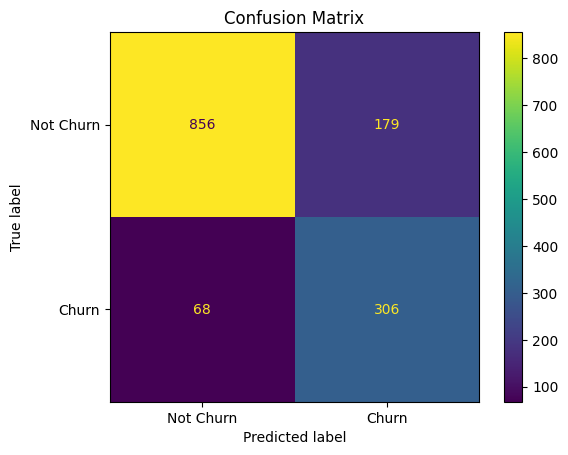

In [42]:
cm = confusion_matrix(y_test, y_pred_best_xg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Churn", "Churn"])
disp.plot(values_format="d")
plt.title("Confusion Matrix")
plt.show()


### 4.4. Results Comparison

In [43]:
def pack_results(name, y_test, y_proba, best_t):
    y_pred = (y_proba >= best_t).astype(int)
    return {
        "Model": name,
        "ROC_AUC": roc_auc_score(y_test, y_proba),
        "Threshold": best_t,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "y_proba": y_proba,
        "y_pred": y_pred
    }


In [44]:
lr_res  = pack_results("Logistic Regression", y_test, y_proba_lr, best_t_lr)
rf_res = pack_results("Random Forest", y_test, y_proba_rf, best_t_rf)
xgb_res = pack_results("XGBoost", y_test, y_proba_xg, best_t_xg)

results = [lr_res, rf_res, xgb_res]

df_compare = pd.DataFrame(results).set_index("Model")
df_compare[["ROC_AUC","Accuracy","Precision","Recall","F1","Threshold"]].sort_values("ROC_AUC", ascending=False)


,ROC_AUC,Accuracy,Precision,Recall,F1,Threshold
Model,,,,,,
XGBoost,0.904097,0.824698,0.630928,0.818182,0.712456,0.30
Random Forest,0.897980,0.825408,0.644796,0.762032,0.698529,0.55
Logistic Regression,0.890625,0.792761,0.577068,0.820856,0.677704,0.30


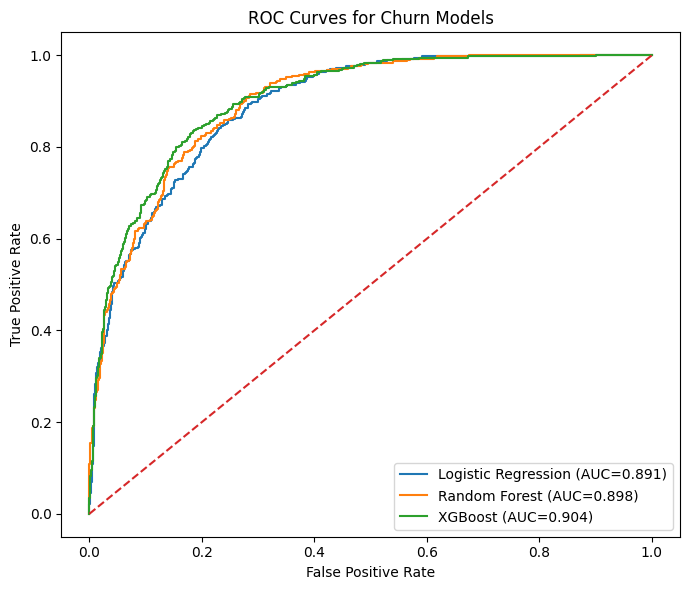

In [45]:
models = {
    "Logistic Regression": best_lr,
    "Random Forest": best_rf,
    "XGBoost": best_xgb
}

plt.figure(figsize=(7,6))

for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--")  # random baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Churn Models")
plt.legend()
plt.tight_layout()
plt.show()
